In [1]:
from config import cfg
from tensorflow.contrib.slim import arg_scope
import tensorflow.contrib.slim as slim

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os, cv2
import argparse

In [2]:
# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (9.0, 6.0) # set default size of plots
plt.rcParams['figure.dpi'] = 100 #分辨率
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [3]:
CLASSES = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')

NETS = {'vgg16': ('vgg16_faster_rcnn_iter_70000.ckpt',),'res101': ('res101_faster_rcnn_iter_110000.ckpt',)}
DATASETS= {'pascal_voc': ('voc_2007_trainval',),'pascal_voc_0712': ('voc_2007_trainval+voc_2012_trainval',)}


def parse_args():
    """Parse input arguments."""
    parser = argparse.ArgumentParser(description='Tensorflow Faster R-CNN demo')
    parser.add_argument('--net', dest='demo_net', help='Network to use [vgg16 res101]',
                        choices=NETS.keys(), default='vgg16')
    parser.add_argument('--dataset', dest='dataset', help='Trained dataset [pascal_voc pascal_voc_0712]',
                        choices=DATASETS.keys(), default='pascal_voc')
    args = parser.parse_args([])

    return args

In [4]:
def _get_blobs(im):
    blobs = {}
    blobs['data'], im_scale_factors = _get_image_blob(im)

    return blobs, im_scale_factors
    

def _get_image_blob(im):
    im_orig = im.astype(np.float32, copy=True)
    im_orig -= cfg.PIXEL_MEANS

    im_shape = im_orig.shape
    im_size_min = np.min(im_shape[0:2])
    im_size_max = np.max(im_shape[0:2])

    processed_ims = []
    im_scale_factors = []

    for target_size in cfg.TEST.SCALES:
        im_scale = float(target_size) / float(im_size_min)
        if np.round(im_scale * im_size_max) > cfg.TEST.MAX_SIZE:
            im_scale = float(cfg.TEST.MAX_SIZE) / float(im_size_max)
        im = cv2.resize(im_orig, None, None, fx=im_scale, fy=im_scale, interpolation=cv2.INTER_LINEAR)
        im_scale_factors.append(im_scale)
        processed_ims.append(im)
    blob = im_list_to_blob(processed_ims)

    return blob, np.array(im_scale_factors)


def im_list_to_blob(ims):
    """Convert a list of images into a network input.

    Assumes images are already prepared (means subtracted, BGR order, ...).
    """
    max_shape = np.array([im.shape for im in ims]).max(axis=0)
    num_images = len(ims)
    blob = np.zeros((num_images, max_shape[0], max_shape[1], 3),
                  dtype=np.float32)
    for i in range(num_images):
        im = ims[i]
        blob[i, 0:im.shape[0], 0:im.shape[1], :] = im

    return blob



image_name = "test.jpg"
im_file = os.path.join('./img/', image_name)
im = cv2.imread(im_file)

blobs, im_scales = _get_blobs(im)

im_blob = blobs['data']
print(im_blob.shape)
blobs['im_info'] = np.array([im_blob.shape[1], im_blob.shape[2], im_scales[0]], dtype=np.float32)
print(blobs['im_info'])

(1, 600, 904, 3)
[600.        904.          1.8072289]


(332, 500, 3)
(1, 600, 904, 3)
[600.        904.          1.8072289]


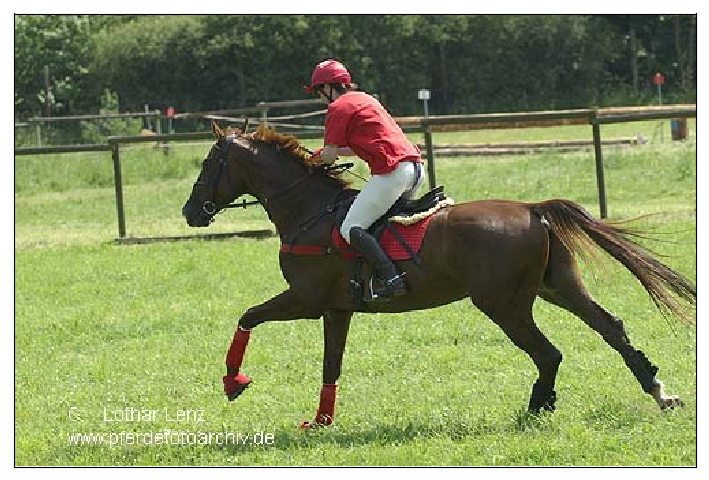

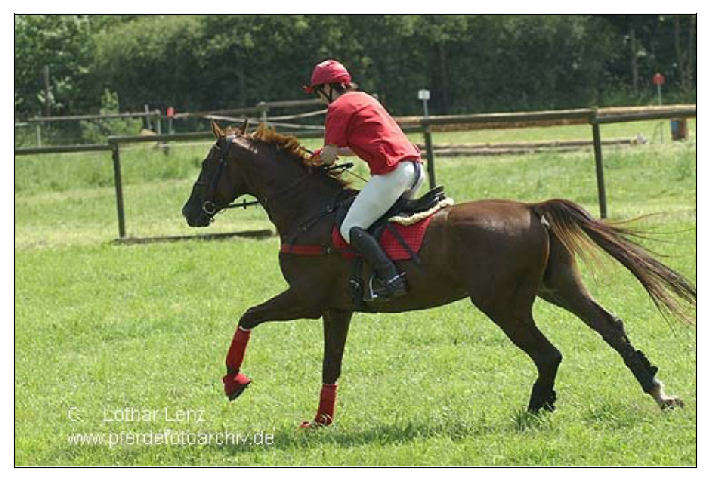

In [5]:
print(im.shape)
print(blobs['data'].shape)
print(blobs['im_info'])
plt.imshow(im[:, :, (2, 1, 0)])
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

img_cell = blobs['data'][0]
img_cell += cfg.PIXEL_MEANS
img_cell[img_cell<1] = 1
img_cell[img_cell>255] = 255
img_cell = img_cell.astype(np.uint8, copy=True)
plt.imshow(img_cell[:, :, (2, 1, 0)])
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()